### OPL and ray tracing calculation for a system with tilted coverslip

1. Coordinate system: XY
  * X is the optical axis of objective, 
  * x=0 at the sample|coverslip boundary

2. units: mm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_sample = 1.3325 #water: 1.33; life worm: 1.37; fixed and mounted in ProLong Gold: 1.47
# n= 1.37 @ 633 nm is C.elegans RI, ref: https://www.ncbi.nlm.nih.gov/pubmed/17694065/
n_glass = 1.5230 #@589 nm, D263M borosilicate glass for coverslips, from Fischer Scientific datasheet
n_media = 1.3325 #water (1.3325), glycerol(1.4722), immersion oil (1.515)
n_mediaArray = np.array([1.3325, 1.4722, 1.515]) #water, glycerol, immersion oil
mediaLabel = ['water','glycerol', 'oil']

tilt_angle = 45./180*np.pi #45-degree tilt of coverslip
thickness_glass = 0.170 #mm, No1.5 standard glass

thetaRadArray = np.linspace(-36.9,36.9,21)/180.0*np.pi ##ray angle from the point source

NA = np.sin(thetaRadArray[-1])*n_media #max NA of the system, using sample refractive index
print 'max NA = ' + str(NA)

max NA = 0.8000599502467403


In [3]:
tilt_angle

0.7853981633974483

Two surfaces of the coverslip

In [4]:
def S1(x,tilt = 0.7853981633974483):
    """ first glass surface, closer to the sample. Default tilt 0.7853981633974483 rad is 45 deg. """
    return x*np.tan(tilt)

def S2(x,tilt = 0.7853981633974483,th_glass = 0.17):
    return x * np.tan(tilt) - th_glass/np.cos(tilt)

In [5]:
def ray_tracing(x0,y0,theta0, tilt, n_sample, n_glass, n_media, th_glass):
    """ Tracing of a ray emanating from point (x0,y0) at angle theta0 using Snell's law
    through tilted glass of thickness th_glass into immersion media, up to x3 axial position
    refr. indices: n_sample, n_glass, n_media,
    """
    # first refraction point
    x1 = x0 * np.tan(theta0)/(np.tan(theta0) - np.tan(tilt))
    y1 = S1(x1, tilt)
    theta1 = np.arcsin(n_sample/n_glass*np.sin(tilt + theta0)) - tilt
    # second refr. point
    x2 = x1 - th_glass/(np.cos(tilt)*(np.tan(theta1) - np.tan(tilt)))
    y2 = S2(x2,tilt,th_glass)
    theta2 = np.arcsin(n_glass/n_media * np.sin(tilt + theta1)) - tilt
    return (x1,y1,theta1, x2,y2,theta2)

Plot the ray fan.

Ignore invalid value warining in arcsin(), this is due to total internal reflection, these rays become 'nan' 

Text(0.8,0.4,'water')

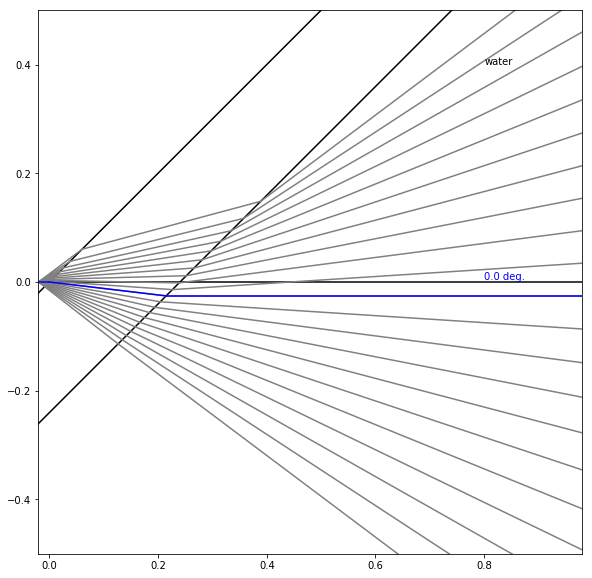

In [6]:
source_posX_mm = -0.02
source_posY_mm = 0
i_medium = 0 #water

fig, ax = plt.subplots(1,1,figsize = (10,10))
x_min = -0.1
x_max = 1.
axialRayInd = np.where(thetaRadArray == 0)[0]

ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')
x0, y0 = source_posX_mm, source_posY_mm
(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                  n_sample, n_glass, n_mediaArray[i_medium], thickness_glass)
x3 = x_max*np.ones(len(thetaRadArray))
y3 = y3 = y2 + (x3-x2)*np.tan(theta2)
#plot all rays
ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray')
ax.plot([x1, x2], [y1, y2],color = 'gray')
ax.plot([x2, x3], [y2, y3],color = 'gray')
#plot axial ray
ax.plot([x0, x1[axialRayInd]], [y0, y1[axialRayInd]],color = 'blue')
ax.plot([x1[axialRayInd], x2[axialRayInd]], [y1[axialRayInd], y2[axialRayInd]],color = 'blue')
ax.plot([x2[axialRayInd], x3[axialRayInd]], [y2[axialRayInd], y3[axialRayInd]],color = 'blue')
# print axis ray angle, deg.
ax.text(0.8, y3[axialRayInd]+0.03, '{:2.1f}'.format(theta2[axialRayInd][0]/np.pi*180) + ' deg.',color='blue')
ax.set_xlim([-0.02, 0.98])
ax.set_ylim([-0.5, 0.5])
ax.text(0.8,0.4,mediaLabel[i_medium])

Find where rays reach the reference sphere (R_refSphere)

In [7]:
def intersectRefSphere(x0,y0,x2,y2,theta2,r):
    """Solve quadratic equation to find where ray3 intersects ref. sphere"""
    a = 1.0 + np.tan(theta2)**2
    b = 2.0*y2*np.tan(theta2) - 2.0*x2*np.tan(theta2)**2 - 2.0*x0
    c = (y2 - y0 - x2*np.tan(theta2))**2 - r**2 + x0**2
    x3_refSphere = (-b + np.sqrt(b**2 - 4.0*a*c))/(2*a)
    y3_refSphere = y2 + (x3_refSphere - x2)*np.tan(theta2)
    return (x3_refSphere, y3_refSphere)

In [8]:
def ref_sphere(x0, y0, r):
    """Generates x,y pairs for drawing a sphere"""
    theta = np.linspace(0,2*np.pi,100)
    return (x0 + r*np.cos(theta), y0 + r*np.sin(theta))

Text(0.5,1,'x0, mm: -0.02')

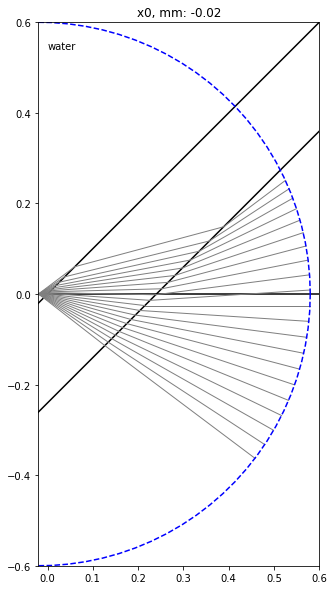

In [9]:
i_medium = 0 #water
n_media = n_mediaArray[i_medium]
x0, y0 = source_posX_mm, source_posY_mm
R_refSphere_mm = 0.6

fig, ax = plt.subplots(1,1,figsize = (10,10))
x_min = -0.1
x_max = R_refSphere_mm
ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')

(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                  n_sample, n_glass, n_mediaArray[i_medium], thickness_glass)

(x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2,theta2,R_refSphere_mm)
ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray',lw = 1)
ax.plot([x1, x2], [y1, y2],color = 'gray',lw = 1)
ax.plot([x2, x3_refSphere], [y2, y3_refSphere],color = 'gray',lw = 1)

(x_sphere,y_sphere) = ref_sphere(x0, y0, R_refSphere_mm)
ax.plot(x_sphere,y_sphere, '--b')
ax.set_xlim([x0, x_max])
ax.set_ylim([-R_refSphere_mm, R_refSphere_mm])
ax.text(0, R_refSphere_mm*0.9, mediaLabel[i_medium])
ax.set_title('x0, mm: ' + str(x0))

## Plot optical path length (OPL) of the rays

In [10]:
i_medium = 0 #water
n_media = n_mediaArray[i_medium]
wl_mm = 0.520e-3 # green wl, vacuum, mm
x0, y0 = source_posX_mm, source_posY_mm
R_refSphere_mm = 5

(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                            n_sample, n_glass, n_media, thickness_glass)

(x3_refSphere, y3_refSphere) = intersectRefSphere(x0,y0,x2,y2, theta2, R_refSphere_mm)

In [11]:
OPL_ref_sphere = n_sample * np.sqrt((x1-x0)**2 + (y1-y0)**2) + \
       n_glass * np.sqrt((x2-x1)**2 + (y2-y1)**2) + \
       n_media * np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)

OPD_ref_sphere = OPL_ref_sphere - np.nanmin(OPL_ref_sphere)

phase_lens_term_paraxial = y3_refSphere**2/R_refSphere_mm
phase_lens_term_full = R_refSphere_mm - np.sqrt(R_refSphere_mm**2 - y3_refSphere**2)

Text(0.5,1,'OPD of an ideal lens, mm')

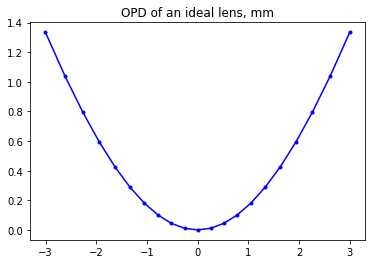

In [54]:
#calculate OPL to the principal plane of ideal infinitely thin lens.
# Distance from pt source to the lens: f x cos(Theta_max)
# no-coverslip, ideal conditions
f_objective_mm = 5.0
OPL_ref_plane_no_coverslip = n_media * f_objective_mm * np.cos(thetaRadArray[-1])/np.cos(thetaRadArray)
OPD_ref_plane_no_coverslip = OPL_ref_plane_no_coverslip - np.nanmin(OPL_ref_plane_no_coverslip)
y_rays_plane_no_coverslip = f_objective_mm * np.cos(thetaRadArray[-1]) * np.tan(thetaRadArray)
plt.plot(y_rays_plane_no_coverslip, OPD_ref_plane_no_coverslip,'.-b')
plt.title("OPD of an ideal lens, mm")

In [55]:
#calculate height (y) where aberrated rays reach the lens principle plane
def intersect_ref_plane(x0,y0, x2,y2, theta2, theta_max_rad, focal_dist_mm = 5.0):
    """Intersect the rays with vertical reference plane representing an ideal lens"""
    x3 = np.ones(x2.shape)*focal_dist_mm*np.cos(theta_max_rad) - x0
    y3 = y2 + (x3 - x2)*np.tan(theta2)
    return (x3, y3)

Text(0.5,1,'x0, mm: -0.02')

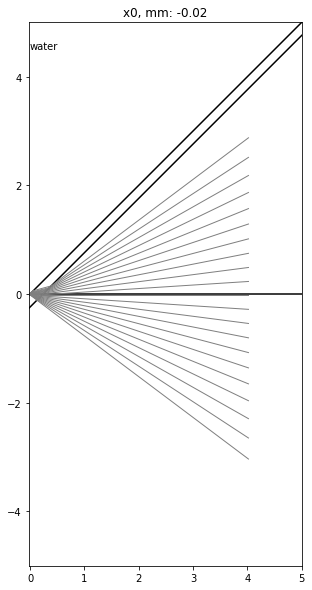

In [57]:
i_medium = 0 #water
n_media = n_mediaArray[i_medium]

fig, ax = plt.subplots(1,1,figsize = (10,10))
x_min = -0.1
x_max = f_objective_mm
ax.plot([x_min, x_max],[S1(x_min), S1(x_max)],'-k')
ax.plot([x_min, x_max],[S2(x_min), S2(x_max)],'-k')
ax.axhline(y=0, color='k')
ax.set_aspect('equal', 'box')

x0, y0 = source_posX_mm, source_posY_mm

(x1,y1,theta1, x2,y2,theta2) = ray_tracing(x0,y0, thetaRadArray, tilt_angle, \
                                  n_sample, n_glass, n_mediaArray[i_medium], thickness_glass)

(x3_ref_plane_coverslip, y3_ref_plane_coverslip) = intersect_ref_plane(x0,y0, x2,y2, theta2, thetaRadArray[-1], f_objective_mm)

ax.plot([x0*np.ones(len(thetaRadArray)), x1], [y0*np.ones(len(thetaRadArray)), y1],color = 'gray',lw = 1)
ax.plot([x1, x2], [y1, y2],color = 'gray',lw = 1)
ax.plot([x2, x3_ref_plane_coverslip], [y2, y3_ref_plane_coverslip],color = 'gray',lw = 1)

ax.set_xlim([x0, x_max])
ax.set_ylim([-f_objective_mm, f_objective_mm])
ax.text(0, f_objective_mm*0.9, mediaLabel[i_medium])
ax.set_title('x0, mm: ' + str(x0))

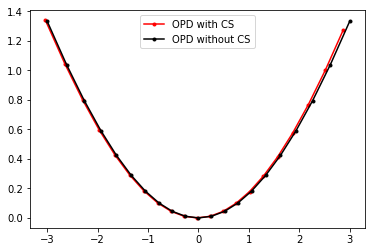

In [58]:
OPL_ref_plane_coverslip = n_sample * np.sqrt((x1 - x0)**2 + (y1 - y0)**2) + \
       n_glass * np.sqrt((x2 - x1)**2 + (y2 - y1)**2) + \
       n_media * np.sqrt((x3_ref_plane_coverslip - x2)**2 + (y3_ref_plane_coverslip - y2)**2)

OPD_ref_plane_coverslip = OPL_ref_plane_coverslip - np.nanmin(OPL_ref_plane_coverslip)
plt.plot(y3_ref_plane_coverslip, OPD_ref_plane_coverslip, '.-r', label="OPD with CS")
plt.plot(y_rays_plane_no_coverslip, OPD_ref_plane_no_coverslip, '.-k', label = "OPD without CS")
plt.legend()

In [59]:
#Spline interpolation of coverslip-case OPD
from scipy import interpolate
tck_OPD_coverslip = interpolate.splrep(y3_ref_plane_coverslip, OPD_ref_plane_coverslip)
OPD_coverslip_interp = interpolate.splev(y_rays_plane_no_coverslip, tck_OPD_coverslip)

In [62]:
OPD_coverslip_interp.shape

(21L,)

In [64]:
tilt_y

array([0.01025223, 0.00374075])

In [67]:
tilt_y_poly = np.poly1d(np.polyfit(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip, 1))
tilt_y_poly(y_rays_plane_no_coverslip)

array([-0.02703747, -0.02309437, -0.01947072, -0.0161024 , -0.01293802,
       -0.00993547, -0.00705939, -0.00427942, -0.00156873,  0.00109705,
        0.00374075,  0.00638444,  0.00905022,  0.01176091,  0.01454088,
        0.01741696,  0.02041952,  0.0235839 ,  0.02695221,  0.03057586,
        0.03451896])

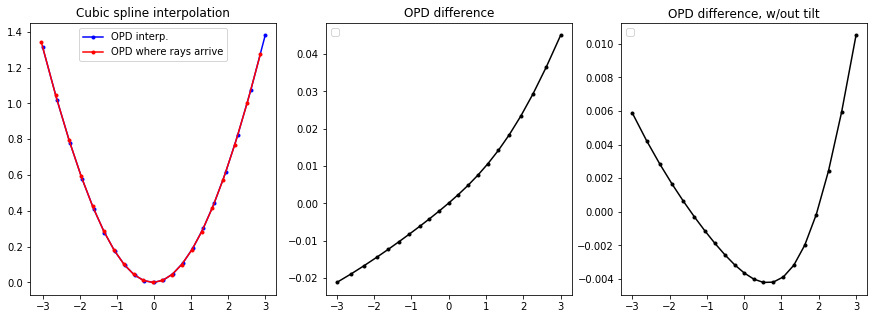

In [69]:
fig, ax = plt.subplots(1,3,figsize = (15,5))

ax[0].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp, '.-b', label = 'OPD interp.')
ax[0].plot(y3_ref_plane_coverslip, OPD_ref_plane_coverslip, '.-r', label = 'OPD where rays arrive')
ax[0].set_title("Cubic spline interpolation")
ax[0].legend()

ax[1].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip, '.-k')
ax[1].set_title("OPD difference")
ax[1].legend()

tilt_y_poly = np.poly1d(np.polyfit(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip, 1))
ax[2].plot(y_rays_plane_no_coverslip, OPD_coverslip_interp - OPD_ref_plane_no_coverslip \
           - tilt_y_poly(y_rays_plane_no_coverslip), '.-k')
ax[2].set_title("OPD difference, w/out tilt")
ax[2].legend()

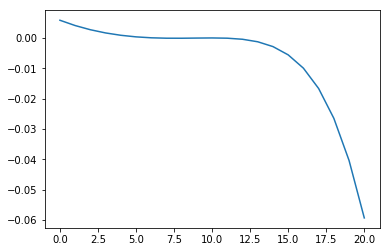

In [21]:
plt.plot(OPD_ref_plane_coverslip - OPD_ref_plane_no_coverslip)

Text(0,0.5,'OPD (lambdas)')

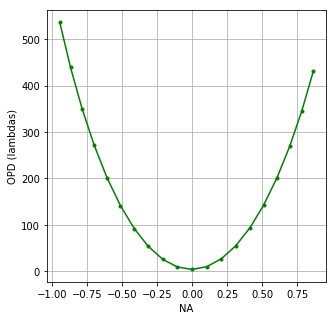

In [159]:
fig, ax = plt.subplots(1,1,figsize = (5,5))
ax.grid()
ax.plot(np.sin(thetaRadArray)*n_sample, (OPD + OPD_lens_term_full)*(n_glass-n_media)/wl, '.-g')
ax.set_xlabel('NA')
ax.set_ylabel('OPD (lambdas)')

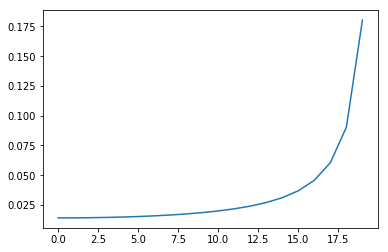

In [119]:
s1 = np.sqrt((x1-x0)**2 + (y1-y0)**2)
plt.plot(s1)

In [121]:
x1

array([-0.01      , -0.00921298, -0.00841616, -0.00759921, -0.0067508 ,
       -0.00585786, -0.00490475, -0.00387199, -0.00273457, -0.00145919,
        0.        ,  0.0017085 ,  0.00376382,  0.00631852,  0.00962611,
        0.01414214,  0.02077684,  0.031653  ,  0.05313752,  0.11706205,
              -inf])

In [122]:
s1

array([0.01414214, 0.01418587, 0.01431842, 0.01454399, 0.01486992,
       0.01530734, 0.01587209, 0.01658629, 0.01748064, 0.01859814,
       0.02      , 0.02177562, 0.02406004, 0.02706636, 0.03115073,
       0.03695518, 0.04576491, 0.06058007, 0.09040294, 0.18024852,
              inf])

C:\Users\nvladim\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in subtract
  if __name__ == '__main__':


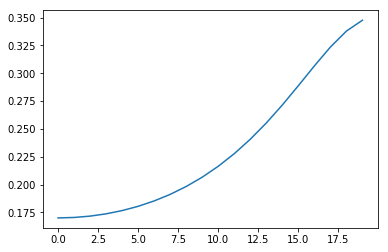

In [123]:
s2 = np.sqrt((x2-x1)**2 + (y2-y1)**2)
plt.plot(s2)

In [125]:
n_media

1.3325

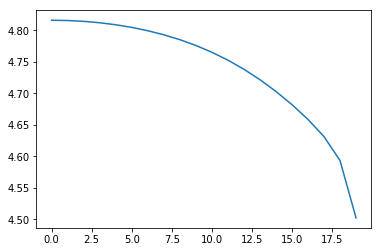

In [130]:
s3 = np.sqrt((x3_refSphere-x2)**2 + (y3_refSphere-y2)**2)
plt.plot(s3)

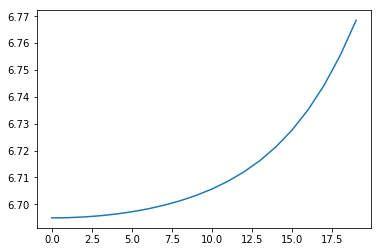

In [134]:
plt.plot(n_sample*s1 + n_glass*s2 + n_media*s3)